In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

%matplotlib notebook

In [10]:
# total_tweets is I
# user_followers_count is S

# Read first 400 timestamps
df = pd.read_csv('data/timeseries/Verified/TRUMP_CHANTING_VERIFIED.csv')
df = df[:400]

yData = np.cumsum(df['total_tweets'])
xData = np.arange(0, len(df), 1)

# Time span for the solve_ivp function
tSpan = [0, len(df)]

# Initial infections at the start
I0 = yData[0]

------------ Parameters -------------
S0 = 26075.008631984656
E0 = 3697.663650416755
Z0 = 4960.285950068849
beta = 0.00010424525783735672
b = 0.061676862047482
ro = 0.17296291342110615
p = 0.032964728489218095
e = 0.02965275728725226
l = 0.024327454154160776




<IPython.core.display.Javascript object>


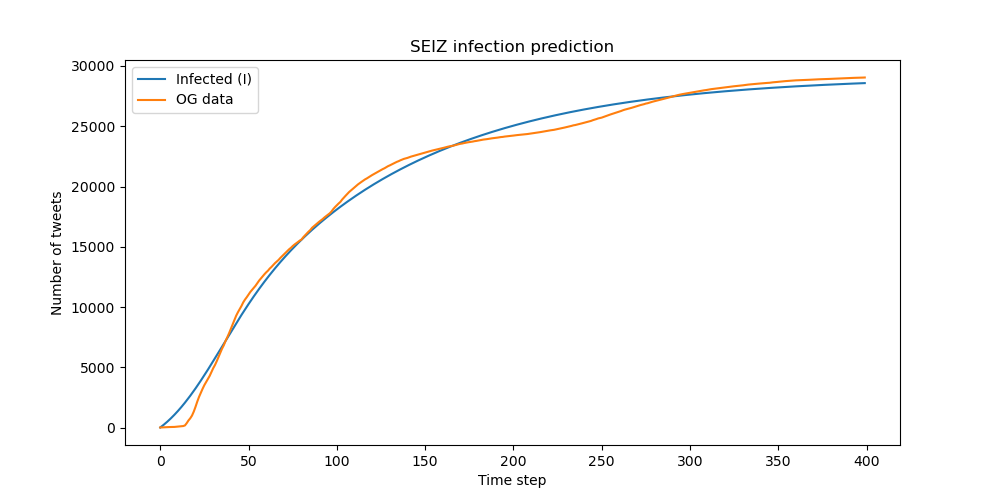

<IPython.core.display.Javascript object>


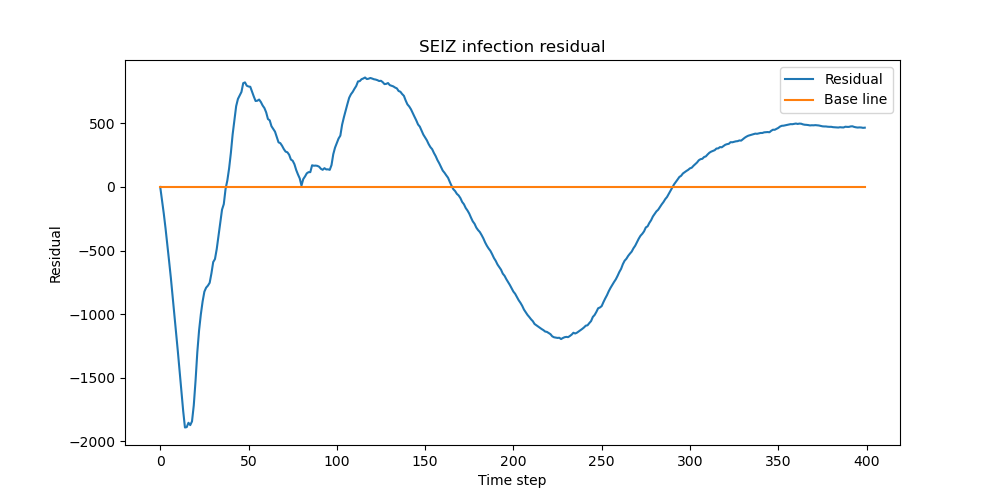

<IPython.core.display.Javascript object>


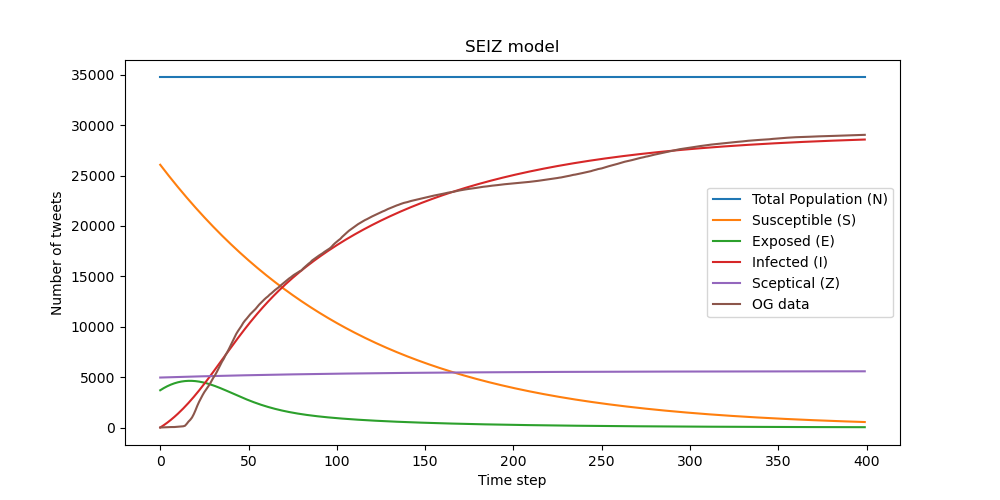

In [109]:
# Run this for the SEIZ model

# Function for SEIZ system of ODEs
# S0, E0, Z0, beta, b, ro, p, e and l are unknown
def seiz(t, y, S0, E0, Z0, beta, b, ro, p, e, l):
    S = y[0]
    E = y[1]
    I = y[2]
    Z = y[3]
    
    N = S0 + E0 + I0 + Z0
    
    dS = -1 * beta * S * (I / N) - b * S * (Z / N)
    dE = (1 - p) * beta * S * (I / N) + (1 - l) * b * S * (Z / N) - ro * E * (I / N) - e * E
    dI = p * beta * S * (I / N) + ro * E * (I / N) + e * E
    dZ = l * b * S * (Z / N)
    
    return [dS, dE, dI, dZ]

def solve_seiz(x, *args):
    initialValues = [args[0], args[1], I0, args[2]] # [S0, E0, I0, Z0]
    
    return solve_ivp(seiz, tSpan, initialValues, method='BDF', t_eval=x, args=args).y

def fit_seiz(x, *args):
    # Return the solution for the infections which we can then compare to the OG data
    return solve_seiz(x, *args)[2]

initial_guess = [100, 100, 100, 1e-20, 1e-20, 1e-20, 1e-20, 1e-20, 1e-20]
bounds = (0, [9e8, 9e8, 9e8, 1, 1, 1, 1, 1, 1]) # All changing parameters should theoretically be between [0, 1]

popt, pcov = curve_fit(fit_seiz, xData, yData, initial_guess, bounds=bounds)

print('------------ Parameters -------------')
print(f'S0 = {popt[0]}')
print(f'E0 = {popt[1]}')
print(f'Z0 = {popt[2]}')
print(f'beta = {popt[3]}')
print(f'b = {popt[4]}')
print(f'ro = {popt[5]}')
print(f'p = {popt[6]}')
print(f'e = {popt[7]}')
print(f'l = {popt[8]}')

# Fitted SEIZ model with the guessed args
fitted = solve_seiz(xData, *popt)

infected_residuals = yData - fitted[2]

# Plotting

# Prediction accuracy
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection prediction')

plt.plot(fitted[2], label='Infected (I)')
plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('seiz_prediction.png')

plt.show()

# Infection residual
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection residual')

plt.plot(infected_residuals, label='Residual')
plt.plot([0] * len(df), label='Base line')

plt.xlabel('Time step')
plt.ylabel('Residual')

plt.legend()

plt.savefig('seiz_residual.png')

plt.show()

# Whole SEIZ model
plt.figure(figsize=(10, 5))
plt.title('SEIZ model')

N = popt[0] + popt[1] + I0 + popt[2]

plt.plot([N] * len(df), label='Total Population (N)')
plt.plot(fitted[0], label='Susceptible (S)')
plt.plot(fitted[1], label='Exposed (E)')
plt.plot(fitted[2], label='Infected (I)')
plt.plot(fitted[3], label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('seiz_model.png')

plt.show()

In [ ]:
# SIR, SIZ and other models will be added later